<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 3 - K-Nearest Neighbors Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn K-Nearest Neighbors](#sklearn-knn)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Estimate National Poverty Rate](#pov-rate)  
[Summary](#summary)

# K-Nearest Neighbors Classifier Introduction <a class="anchor" id="introduction"></a>

Among the simplest of discriminative supervised classification algorithms, K-nearest neighbors (KNN) merely computes the distances (or similarities) between all training points and then uses a majority vote among the k closest (or most similar) neigbors to classify a new point. For example, if there are two classes and $k=3$, a new data point is classified as whichever class has $2$ or $3$ instances among the $3$ closest data to the new point. Because KNN computes on the raw training data, no learning is required to make a classification. However, KNN has the drawback of becoming computationally expensive as the size of the training dataset increases.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** The most important assumptions for KNN are (1) the chosen distance metric and (2) the number of neighbors $K$ to be considered during classification. KNN is a discriminative, non-parametric algorithm. 

While not inherently probabilistic, it is possible to view KNN probabilistically as computing the discriminative posterior $p(y|x,D)$ for classes $y$, feature vector $x$, and data set $D=\{(x^{(1)},y^{(1)}),\dots,(x^{(n)},y^{(n)})\}$. The posterior is taken to be the fraction of neighbors whose class maximizes the probability of the data, in other words the winner of the majority-vote just as described above. As the size of the training set approaches infinity, the error rate for the $K=1$ KNN classifer approaches the minimum possible error rate given the data distribution. 

**Algorithm and Training.** Once pairwise distances between all training points are computed, no further training is required. New data are simply compared to their $K$ closest neighbors, each with a class label, and the majority class is chosen as the class of the new data.

<img src="img/knn.png" width="500" height="500">

## Considerations <a class="anchor" id="introduction-considerations"></a>

KNN's primary drawback is the computational expense of computing the similarity metric for all pairs of data when the training set is large. It may also be neccessary to perform dimensionality reduction to efficiently implement KNN. 

The choice of `K` has a significant impact on the model performance. A larger number of neighbors can help increase model performance when the dataset is noisy, but it will also be more computationally expensive.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'knn'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn K-Nearest Neighbors Model <a class="anchor" id="sklearn-knn"></a>

We'll build the basic model first with a basic set of features for simplicity. We'll use the `load_data` function from `load_data.py` to load and pre-process the data as we did in previous notebooks. 

Once again we will standardize the numeric columns, which is default in our `load_data` function. Standardization can have a significant impact on KNN because the neighbors are typically calculated using a distance metric. By standardizing the data, we remove possible negative scaling effects from features with a larger variance.

The default value for `n_neighbors` in the Scikit-Learn KNeighborsClassifier method is 5. We will use that to begin and then explore methods to find a better value of `K` for this dataset.

KNN can take a long time to run, especially on large datasets. Beause of this, we'll add a `SUBSAMPLE` variable to downsample the size of the dataset by default. To run these algorithms across all of the data, set `SUBSAMPLE = 1`. Results will not match the published results when the notebook only uses a portion of the training data.

In [3]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


CPU times: user 3.31 ms, sys: 0 ns, total: 3.31 ms
Wall time: 3.33 ms
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 18.9 ms
In-sample score: 78.65%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


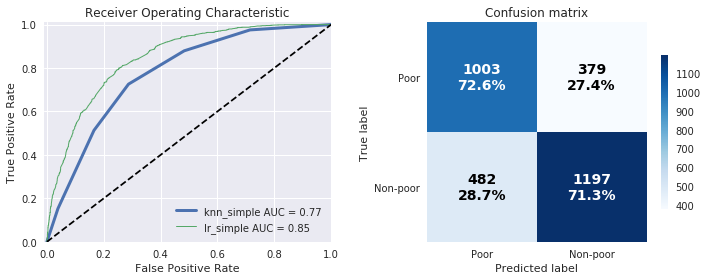

,knn_simple,lr_simple
accuracy,0.718719,0.766743
recall,0.72576,0.738784
precision,0.675421,0.743086
f1,0.699686,0.740929
cross_entropy,1.59216,0.478969
roc_auc,0.774297,0.847856
cohen_kappa,0.435811,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 60.57% 


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Fit the model
model = KNeighborsClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

This basic model performs somewhat worse than our simple Logistic Regression model when we use the default parameters. Let's try again with a larger value of `n_neighbors` and see what the impact is. The value of `n_neighbors` is typically chosen to be odd, since the class will be chosen on a majority vote.

CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 3.64 ms
CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 22.3 ms
In-sample score: 76.47%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


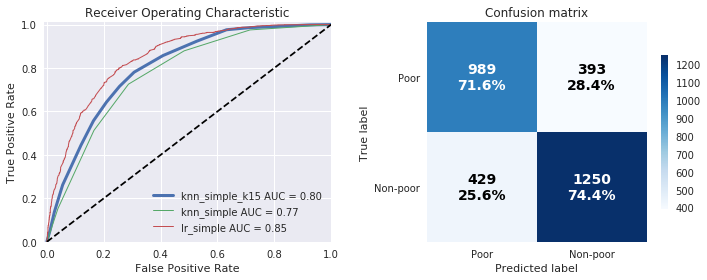

,knn_simple_k15,knn_simple,lr_simple
accuracy,0.73146,0.718719,0.766743
recall,0.71563,0.72576,0.738784
precision,0.697461,0.675421,0.743086
f1,0.706429,0.699686,0.740929
cross_entropy,0.554597,1.59216,0.478969
roc_auc,0.802642,0.774297,0.847856
cohen_kappa,0.459063,0.435811,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 60.51% 


In [6]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = KNeighborsClassifier(n_neighbors=15)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['knn_simple', 
                                                    'lr_simple'],
                                    store_model=True,
                                    model_name='simple_k15', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

With `n_neighbors=15` the performance seems to improve. This gives us a reason to suspect that the optimal number for `n_neighbors` will be higher than the default value, so let's keep 15 for now and apply the classifier with the full set of features.

## KNN with all features <a class="anchor" id="all-feats"></a>

Like with the LDA classifier, we cannot train the Scikit-Learn version of KNN with sample weights. However, we can apply the weights in the scoring method.

CPU times: user 22.1 ms, sys: 4.37 ms, total: 26.5 ms
Wall time: 54.5 ms
CPU times: user 1.07 s, sys: 5.82 ms, total: 1.08 s
Wall time: 1.47 s
In-sample score: 74.21%
CPU times: user 3.5 s, sys: 15.5 ms, total: 3.51 s
Wall time: 10.2 s
CPU times: user 3.56 s, sys: 0 ns, total: 3.56 s
Wall time: 9.2 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


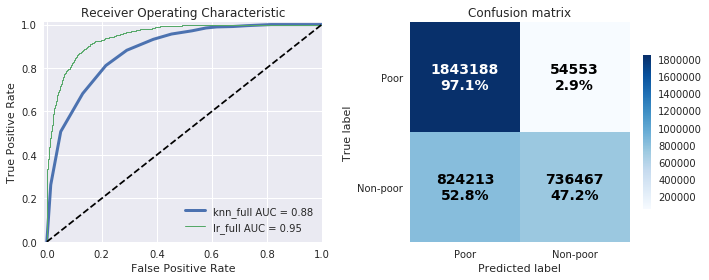

,knn_full,lr_full
accuracy,0.745905,0.873897
recall,0.971254,0.869754
precision,0.691005,0.853693
f1,0.807505,0.861649
cross_entropy,0.68906,0.288223
roc_auc,0.881738,0.948658
cohen_kappa,0.430777,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 77.66% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = KNeighborsClassifier(n_neighbors=15)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

We get much better results when using the full set of features. In particular, this model gives us a much higher recall than the other models we've seen so far, at nearly 93%. This is very good if we are trying to minimize the number of poor households that are misclassified. However, the precision is fairly low, so we also end up classifing many non-poor households as poor. 

We also notice that the model's `fit` method is very fast, which makes sense because we are really only loading in the training data rather than fitting an algorithm to it. The `score` method is much slower and computationally expensive since we now have to estimate the distances for hundreds of features to find the nearest neighbors of a datapoint. 

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

Now let's try to find the best value of `n_neighbors` using GridSearchCV. We can also explore different [distance metrics](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), or try changing the weights function from `uniform` to `distance`. Since KNN can be computationally expensive, we'll just try to optimize the `n_neighbors` parameter here.

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6902173913043478, total=   0.7s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .......... n_neighbors=3, score=0.7336956521739131, total=   0.3s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ........... n_neighbors=3, score=0.717391304347826, total=   0.2s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s


[CV] .......... n_neighbors=3, score=0.6521739130434783, total=   0.7s
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.7472527472527473, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.6793478260869565, total=   0.2s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.7228260869565217, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.7336956521739131, total=   0.6s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.6902173913043478, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] .......... n_neighbors=5, score=0.7527472527472527, total=   0.7s
[CV] n_neighbors=7 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.0min finished


CPU times: user 1.07 s, sys: 509 µs, total: 1.07 s
Wall time: 2.34 s
In-sample score: 77.02%
Best model parameters: {'n_neighbors': 5}
CPU times: user 3.39 s, sys: 7.63 ms, total: 3.4 s
Wall time: 5.29 s
CPU times: user 3.49 s, sys: 19.6 ms, total: 3.51 s
Wall time: 5.91 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


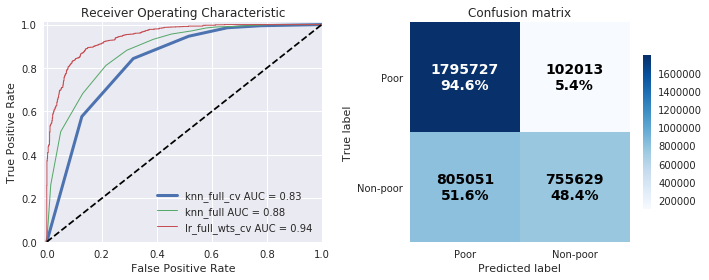

,knn_full_cv,knn_full,lr_full_wts_cv
accuracy,0.737723,0.745905,0.873458
recall,0.946245,0.971254,0.891581
precision,0.690458,0.691005,0.87947
f1,0.798364,0.807505,0.885484
cross_entropy,2.43858,0.68906,0.300498
roc_auc,0.827374,0.881738,0.944474
cohen_kappa,0.432714,0.430777,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 75.14% 


In [8]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# build the model
estimator = KNeighborsClassifier()
parameters = {'n_neighbors': [3,5,7,9,11,13,15]}


model = GridSearchCV(estimator, parameters, verbose=4, cv=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['knn_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv',
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

Using grid search, we find the best value for `n_neighbors` to be 7, though we only get a minor performance boost and actually have a decreased recall rate. 

# KNN Malawi Summary <a class="anchor" id="summary"></a>


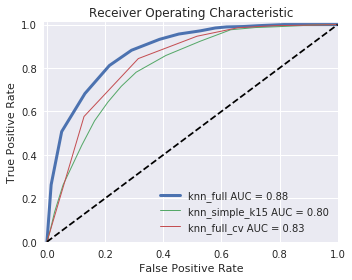

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
knn_full,0.745905,0.971254,0.691005,0.807505,0.68906,0.881738,0.430777,0.235539
knn_simple_k15,0.73146,0.71563,0.697461,0.706429,0.554597,0.802642,0.459063,0.0640664
knn_full_cv,0.737723,0.946245,0.690458,0.798364,2.43858,0.827374,0.432714,0.210347


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)